<a href="https://colab.research.google.com/github/nyjinnn/images/blob/main/week5_quiz_regression_220630_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression

## 자동차 연비 예측하기: 회귀 
1. 데이터셋 불러오기 

In [196]:
# 산점도 행렬을 그리기 위해 seaborn 패키지를 설치합니다
!pip install seaborn
import torch
import random
import torch.nn as nn 
import pathlib
import numpy as np 

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
print(tf.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.8.2


In [197]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [199]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset = dataset.dropna()
dataset.tail()

scaler = StandardScaler()
X_scaled = scaler.fit(dataset).transform(dataset)

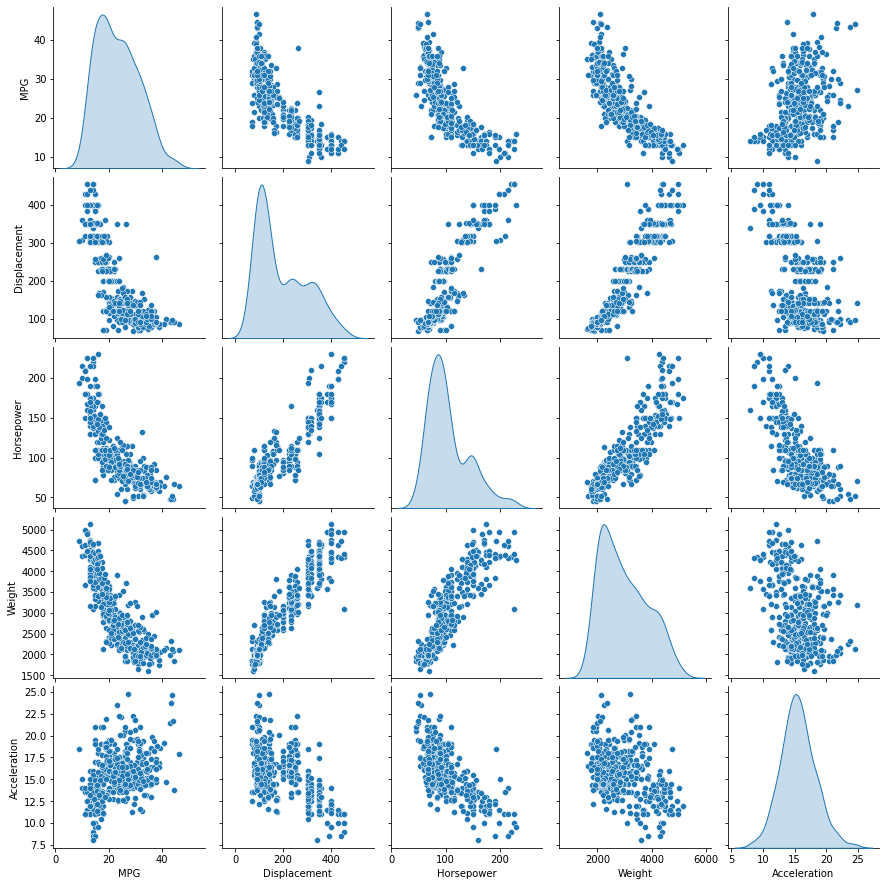

In [200]:
sns.pairplot(dataset[["MPG", "Displacement", "Horsepower", "Weight", "Acceleration", ]], diag_kind="kde")

MPG = 연비, Cylinders = 실린더 개수, Displacement = 배기량, Horseposer = 마력, Weight = 중량, Acceleration = 가속

2. 데이터셋을 numpy로 수정하고 학습 데이터셋 준비

In [203]:
dataset = dataset.to_numpy()
# x = dataset[:, 1:]
# y = dataset[:, 0]

x = np.concatenate([dataset[:, 2:4], dataset[:, 5:7]], axis=1)
y = dataset[:, 0]

# x = dataset[:, 2:7]
# x[:, 3] /= 10 

# cancer_data = np.concatenate([cancer.data[:,0:3], cancer.data[:,4:13], cancer.data[:,14:23], cancer.data[:,24:]], axis =1)

print("car_data:", np.shape(x))

car_data: (392, 4)


In [204]:
#standardScaler = StandardScaler().fit(x)
#X_train_standard = standardScaler.transform(x)
scaler = StandardScaler()   
scaler = scaler.fit_transform(dataset)

In [205]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)  # 수정 금지 
x_train, x_eval, y_train, y_eval = train_test_split(x_train, y_train, test_size=0.125, random_state=999)

x_train_torch = torch.FloatTensor(x_train)
y_train_torch = torch.FloatTensor(y_train)
x_eval_torch = torch.FloatTensor(x_eval)
y_eval_torch = torch.FloatTensor(y_eval) 
x_test_torch = torch.FloatTensor(x_test)
y_test_torch = torch.FloatTensor(y_test)

In [214]:
class RegressionNeuron(nn.Module):
  def __init__(self, in_dim=7, n_hidden=32, learning_rate=1e-5):
    '''
    Args:
      in_dim: The dimension of input data  
      n_hidden: The dimension of hidden layer
      learning_rate: The initial learning rate for training a network 
    '''
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(in_dim, 16),
        nn.ReLU(), 
        nn.Linear(16, 32),
        nn.ReLU(),
        nn.Linear(32, 16),
        nn.GELU(),
        nn.Linear(16, 1)
        )
    
    self.optim = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    self.criterion = nn.MSELoss()

  def _calculate_loss(self, x, y):
    loss = self.criterion(x, y)
    return loss 

  def forward(self, x):
    z = self.model(x)
    return z

  def train(self, x, y, epochs=50):
    for i in range(epochs):
      for x_i, y_i in zip(x, y):
        pred_y = self.forward(x_i)
        loss = self._calculate_loss(pred_y[0], y_i)
        self.model.zero_grad() 
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

      if (i+1) % 1 == 0:  # 여기 나누는 값을 조정해서 프린트하는 횟수를 조절
        eval_loss = np.mean((self.predict(x_eval_torch) - y_eval)**2)
        print("epoch {} : err = {:.9f}, eval err = {:.9f}".format(i + 1, loss, eval_loss))

  def predict(self, x):
    output = self.forward(x)
    output = output.data.numpy() 
    return output 

In [219]:
random_seed = 740
np.random.seed(random_seed)
torch.manual_seed(random_seed)
random.seed(random_seed)

neuron = RegressionNeuron(in_dim=4, n_hidden=32, learning_rate=1e-4)
neuron.train(x_train_torch, y_train_torch,9)

epoch 1 : err = 463.183074951, eval err = 317.388414614
epoch 2 : err = 201.645904541, eval err = 144.618505554
epoch 3 : err = 150.039352417, eval err = 128.008658606
epoch 4 : err = 132.629608154, eval err = 117.702129422
epoch 5 : err = 110.318786621, eval err = 104.810216586
epoch 6 : err = 89.488265991, eval err = 92.123996195
epoch 7 : err = 56.434745789, eval err = 74.569694636
epoch 8 : err = 37.021434784, eval err = 65.494772737
epoch 9 : err = 20.221153259, eval err = 63.498431519


In [220]:
output = np.mean((neuron.predict(x_test_torch) - y_test)**2)
print(output)

55.55181523611923
